In [1]:
import os.path
import cv2
import os
import json
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def extract_video_frames(video_filename):
    video = cv2.VideoCapture(video_filename)

    try:
        video_path = Path(video_filename)
        video_parent_directory_path = os.path.dirname(video_path)
        # creating a folder named VideoFrames
        video_frames_path_name = f'{video_parent_directory_path}/VideoFrames'
        if not os.path.exists(video_frames_path_name):
            os.makedirs(video_frames_path_name)

    # if not created then raise error
    except OSError:
        print (f'Error: Creating directory {video_frames_path_name}')

    # frame
    current_frame = 0

    while(True):

        # reading from frame
        ret, frame = video.read()

        if ret:
            # if video is still left continue creating images
            frame_name = f'{video_parent_directory_path}/VideoFrames/frame{current_frame}.jpg'
            print ('Creating...' + frame_name)

            # writing the extracted images
            cv2.imwrite(frame_name, frame)

            current_frame += 1
        else:
            break


    return current_frame

def extract_depth_map(depth_bytes_filename, depth_metadata_filename):
    # Parse the metadata JSON so we can understand how to parse bytes file
    f = open(depth_metadata_filename)
    metadata_json = json.load(f)
    print("Printing depth metadata:")
    print(metadata_json)
    
    depth_map_number_of_bytes = metadata_json['bytesPerRow'] * metadata_json['height']
    
    depth_bytes_file = open(depth_bytes_filename, 'rb')
    
    try:
        depth_bytes_path = Path(depth_bytes_filename)
        depth_bytes_parent_directory_path = os.path.dirname(depth_bytes_path)
        # creating a folder named DepthMaps
        depth_maps_path_name = f'{depth_bytes_parent_directory_path}/DepthMaps'
        if not os.path.exists(depth_maps_path_name):
            os.makedirs(depth_maps_path_name)

    # if not created then raise error
    except OSError:
        print (f'Error: Creating directory {depth_maps_path_name}')
        
    # frame
    current_frame = 0

    while(True):

        # reading from buffer
        depth_map_buffer = depth_bytes_file.read(depth_map_number_of_bytes)
        if depth_map_buffer:
            deserialized_bytes = np.frombuffer(depth_map_buffer, dtype=np.float32)
            depth_map = np.reshape(deserialized_bytes, newshape=(metadata_json['height'], metadata_json['width']))
#             print("Printing depth map:")
#             print(depth_map)

#             print("Printing depth map shape:")
#             print(depth_map.shape)
            
            depth_map_name = f'{depth_bytes_parent_directory_path}/DepthMaps/frame{current_frame}.npy'
            print ('Creating...' + depth_map_name)
            
            np.save(depth_map_name, depth_map)
            
            current_frame += 1
        else:
            break
            
    return current_frame  

def extract_frames_and_depth_map(video_filename, depth_bytes_filename, depth_metadata_filename):
    video_frames_count = extract_video_frames(video_filename)
    depth_maps_count = extract_depth_map(depth_bytes_filename, depth_metadata_filename)
    print(f"Number of video frames:{video_frames_count}")
    print(f"Number of depth maps:{depth_maps_count}")
    return (video_frames_count == depth_maps_count), video_frames_count
    
def plot_video_and_depth_map(frame_filename, depth_map_filename):
    depth_map = np.load(depth_map_filename)
    frame_image = mpimg.imread(frame_filename)
    
    smallest_depth_value = depth_map.min()
    largest_depth_value = depth_map.max()
#     print("Printing depth map:")
#     print(depth_map)
#     print(f"Min value: {smallest_depth_value}")
#     print(f"Max value: {largest_depth_value}")
#     print("\n")
    
    fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
    fig1.suptitle(f'Depth Color Map\nColor map range is from {smallest_depth_value}m to {largest_depth_value}m\nDepth Map Filename: {depth_map_filename}\nImage Filename: {frame_filename}')

    ax1.set_title('Color map of depth')
    ax1.set_xlabel('Pixel column')
    ax1.set_ylabel('Pixel row')
    ax1img = ax1.imshow(depth_map, cmap="plasma", vmin=smallest_depth_value, vmax=largest_depth_value)
    fig1.colorbar(ax1img, ax = ax1)

    ax2.set_title('RGB image')
    ax2.set_xlabel('Pixel column')
    ax2.set_ylabel('Pixel row')
    ax2.imshow(frame_image)

    fig1.tight_layout()
    
def get_immediate_depth_data_subdirectories(a_dir):
    return [name for name in os.listdir(a_dir)
            if os.path.isdir(os.path.join(a_dir, name)) and name.startswith('DepthData')] 

# Need to place the 3 files (video.mp4, DepthDataBytes, DepthDataMetadata.json) in a directory that is prefixed with "DepthData"
# This "DepthData" prefixed directory should be at the root of this project
def main(plot_data = False):
    depth_data_subdirectories = get_immediate_depth_data_subdirectories('.')
    plot_interval = 5
    for directory in depth_data_subdirectories:
        extraction_success, frames_count = extract_frames_and_depth_map(f'{directory}/video.mp4', f'{directory}/DepthDataBytes', f'{directory}/DepthDataMetadata.json')
        if plot_data:
            if extraction_success:
                for i in range(frames_count):
                    if i % plot_interval == 0:
                        frame_filename = f'{directory}/VideoFrames/frame{i}.jpg'
                        depth_map_filename = f'{directory}/DepthMaps/frame{i}.npy'
                        plot_video_and_depth_map(frame_filename, depth_map_filename)

            else:
                print("Error: Video frame count and depth map count is not the same")
    

Creating...DepthData_20220217T13-26-48-0800_EA57AA77-1AA8-4082-B672-BD57B3EA4326/VideoFrames/frame0.jpg
Creating...DepthData_20220217T13-26-48-0800_EA57AA77-1AA8-4082-B672-BD57B3EA4326/VideoFrames/frame1.jpg
Creating...DepthData_20220217T13-26-48-0800_EA57AA77-1AA8-4082-B672-BD57B3EA4326/VideoFrames/frame2.jpg
Creating...DepthData_20220217T13-26-48-0800_EA57AA77-1AA8-4082-B672-BD57B3EA4326/VideoFrames/frame3.jpg
Creating...DepthData_20220217T13-26-48-0800_EA57AA77-1AA8-4082-B672-BD57B3EA4326/VideoFrames/frame4.jpg
Creating...DepthData_20220217T13-26-48-0800_EA57AA77-1AA8-4082-B672-BD57B3EA4326/VideoFrames/frame5.jpg
Creating...DepthData_20220217T13-26-48-0800_EA57AA77-1AA8-4082-B672-BD57B3EA4326/VideoFrames/frame6.jpg
Creating...DepthData_20220217T13-26-48-0800_EA57AA77-1AA8-4082-B672-BD57B3EA4326/VideoFrames/frame7.jpg
Creating...DepthData_20220217T13-26-48-0800_EA57AA77-1AA8-4082-B672-BD57B3EA4326/VideoFrames/frame8.jpg
Creating...DepthData_20220217T13-26-48-0800_EA57AA77-1AA8-4082-B

Printing depth metadata:
{'pixelFormatType': 'kCVPixelFormatType_DepthFloat32', 'width': 144, 'height': 256, 'bytesPerRow': 576}
Creating...DepthData_20220217T13-26-36-0800_435CC698-EAAB-47AB-8DAC-232771CF3520/DepthMaps/frame0.npy
Creating...DepthData_20220217T13-26-36-0800_435CC698-EAAB-47AB-8DAC-232771CF3520/DepthMaps/frame1.npy
Creating...DepthData_20220217T13-26-36-0800_435CC698-EAAB-47AB-8DAC-232771CF3520/DepthMaps/frame2.npy
Creating...DepthData_20220217T13-26-36-0800_435CC698-EAAB-47AB-8DAC-232771CF3520/DepthMaps/frame3.npy
Creating...DepthData_20220217T13-26-36-0800_435CC698-EAAB-47AB-8DAC-232771CF3520/DepthMaps/frame4.npy
Creating...DepthData_20220217T13-26-36-0800_435CC698-EAAB-47AB-8DAC-232771CF3520/DepthMaps/frame5.npy
Creating...DepthData_20220217T13-26-36-0800_435CC698-EAAB-47AB-8DAC-232771CF3520/DepthMaps/frame6.npy
Creating...DepthData_20220217T13-26-36-0800_435CC698-EAAB-47AB-8DAC-232771CF3520/DepthMaps/frame7.npy
Creating...DepthData_20220217T13-26-36-0800_435CC698-EA

/var/folders/fr/89d7f2117vq739rlbm5st42r0000gn/T/ipykernel_37475/2577277367.py:117: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)


Creating...DepthData 3/VideoFrames/frame0.jpg
Creating...DepthData 3/VideoFrames/frame1.jpg
Creating...DepthData 3/VideoFrames/frame2.jpg
Creating...DepthData 3/VideoFrames/frame3.jpg
Creating...DepthData 3/VideoFrames/frame4.jpg
Creating...DepthData 3/VideoFrames/frame5.jpg
Creating...DepthData 3/VideoFrames/frame6.jpg
Creating...DepthData 3/VideoFrames/frame7.jpg
Creating...DepthData 3/VideoFrames/frame8.jpg
Creating...DepthData 3/VideoFrames/frame9.jpg
Creating...DepthData 3/VideoFrames/frame10.jpg
Creating...DepthData 3/VideoFrames/frame11.jpg
Creating...DepthData 3/VideoFrames/frame12.jpg
Creating...DepthData 3/VideoFrames/frame13.jpg
Creating...DepthData 3/VideoFrames/frame14.jpg
Creating...DepthData 3/VideoFrames/frame15.jpg
Creating...DepthData 3/VideoFrames/frame16.jpg
Creating...DepthData 3/VideoFrames/frame17.jpg
Creating...DepthData 3/VideoFrames/frame18.jpg
Creating...DepthData 3/VideoFrames/frame19.jpg
Creating...DepthData 3/VideoFrames/frame20.jpg
Creating...DepthData 3/

Creating...DepthData 4/VideoFrames/frame24.jpg
Creating...DepthData 4/VideoFrames/frame25.jpg
Creating...DepthData 4/VideoFrames/frame26.jpg
Creating...DepthData 4/VideoFrames/frame27.jpg
Creating...DepthData 4/VideoFrames/frame28.jpg
Creating...DepthData 4/VideoFrames/frame29.jpg
Creating...DepthData 4/VideoFrames/frame30.jpg
Creating...DepthData 4/VideoFrames/frame31.jpg
Creating...DepthData 4/VideoFrames/frame32.jpg
Creating...DepthData 4/VideoFrames/frame33.jpg
Creating...DepthData 4/VideoFrames/frame34.jpg
Creating...DepthData 4/VideoFrames/frame35.jpg
Creating...DepthData 4/VideoFrames/frame36.jpg
Creating...DepthData 4/VideoFrames/frame37.jpg
Creating...DepthData 4/VideoFrames/frame38.jpg
Creating...DepthData 4/VideoFrames/frame39.jpg
Creating...DepthData 4/VideoFrames/frame40.jpg
Creating...DepthData 4/VideoFrames/frame41.jpg
Creating...DepthData 4/VideoFrames/frame42.jpg
Creating...DepthData 4/VideoFrames/frame43.jpg
Creating...DepthData 4/VideoFrames/frame44.jpg
Creating...De

Creating...DepthData/VideoFrames/frame13.jpg
Creating...DepthData/VideoFrames/frame14.jpg
Creating...DepthData/VideoFrames/frame15.jpg
Creating...DepthData/VideoFrames/frame16.jpg
Creating...DepthData/VideoFrames/frame17.jpg
Creating...DepthData/VideoFrames/frame18.jpg
Creating...DepthData/VideoFrames/frame19.jpg
Creating...DepthData/VideoFrames/frame20.jpg
Creating...DepthData/VideoFrames/frame21.jpg
Creating...DepthData/VideoFrames/frame22.jpg
Creating...DepthData/VideoFrames/frame23.jpg
Creating...DepthData/VideoFrames/frame24.jpg
Creating...DepthData/VideoFrames/frame25.jpg
Creating...DepthData/VideoFrames/frame26.jpg
Creating...DepthData/VideoFrames/frame27.jpg
Creating...DepthData/VideoFrames/frame28.jpg
Creating...DepthData/VideoFrames/frame29.jpg
Creating...DepthData/VideoFrames/frame30.jpg
Creating...DepthData/VideoFrames/frame31.jpg
Creating...DepthData/VideoFrames/frame32.jpg
Creating...DepthData/VideoFrames/frame33.jpg
Creating...DepthData/VideoFrames/frame34.jpg
Creating..

Creating...DepthData_20220217T13-28-58-0800_9C944D42-CAC5-4D15-B3C5-9F4F8E812B8B/VideoFrames/frame0.jpg
Creating...DepthData_20220217T13-28-58-0800_9C944D42-CAC5-4D15-B3C5-9F4F8E812B8B/VideoFrames/frame1.jpg
Creating...DepthData_20220217T13-28-58-0800_9C944D42-CAC5-4D15-B3C5-9F4F8E812B8B/VideoFrames/frame2.jpg
Creating...DepthData_20220217T13-28-58-0800_9C944D42-CAC5-4D15-B3C5-9F4F8E812B8B/VideoFrames/frame3.jpg
Creating...DepthData_20220217T13-28-58-0800_9C944D42-CAC5-4D15-B3C5-9F4F8E812B8B/VideoFrames/frame4.jpg
Creating...DepthData_20220217T13-28-58-0800_9C944D42-CAC5-4D15-B3C5-9F4F8E812B8B/VideoFrames/frame5.jpg
Creating...DepthData_20220217T13-28-58-0800_9C944D42-CAC5-4D15-B3C5-9F4F8E812B8B/VideoFrames/frame6.jpg
Creating...DepthData_20220217T13-28-58-0800_9C944D42-CAC5-4D15-B3C5-9F4F8E812B8B/VideoFrames/frame7.jpg
Creating...DepthData_20220217T13-28-58-0800_9C944D42-CAC5-4D15-B3C5-9F4F8E812B8B/VideoFrames/frame8.jpg
Creating...DepthData_20220217T13-28-58-0800_9C944D42-CAC5-4D15-B

Creating...DepthData_20220217T13-29-14-0800_B46E31C5-7767-4378-A43E-996D8EA3AF96/VideoFrames/frame0.jpg
Creating...DepthData_20220217T13-29-14-0800_B46E31C5-7767-4378-A43E-996D8EA3AF96/VideoFrames/frame1.jpg
Creating...DepthData_20220217T13-29-14-0800_B46E31C5-7767-4378-A43E-996D8EA3AF96/VideoFrames/frame2.jpg
Creating...DepthData_20220217T13-29-14-0800_B46E31C5-7767-4378-A43E-996D8EA3AF96/VideoFrames/frame3.jpg
Creating...DepthData_20220217T13-29-14-0800_B46E31C5-7767-4378-A43E-996D8EA3AF96/VideoFrames/frame4.jpg
Creating...DepthData_20220217T13-29-14-0800_B46E31C5-7767-4378-A43E-996D8EA3AF96/VideoFrames/frame5.jpg
Creating...DepthData_20220217T13-29-14-0800_B46E31C5-7767-4378-A43E-996D8EA3AF96/VideoFrames/frame6.jpg
Creating...DepthData_20220217T13-29-14-0800_B46E31C5-7767-4378-A43E-996D8EA3AF96/VideoFrames/frame7.jpg
Creating...DepthData_20220217T13-29-14-0800_B46E31C5-7767-4378-A43E-996D8EA3AF96/VideoFrames/frame8.jpg
Creating...DepthData_20220217T13-29-14-0800_B46E31C5-7767-4378-A

Creating...DepthData_20220217T13-23-49-0800_6A43C053-5CB1-4D77-B12D-96851300FF3A/VideoFrames/frame0.jpg
Creating...DepthData_20220217T13-23-49-0800_6A43C053-5CB1-4D77-B12D-96851300FF3A/VideoFrames/frame1.jpg
Creating...DepthData_20220217T13-23-49-0800_6A43C053-5CB1-4D77-B12D-96851300FF3A/VideoFrames/frame2.jpg
Creating...DepthData_20220217T13-23-49-0800_6A43C053-5CB1-4D77-B12D-96851300FF3A/VideoFrames/frame3.jpg
Creating...DepthData_20220217T13-23-49-0800_6A43C053-5CB1-4D77-B12D-96851300FF3A/VideoFrames/frame4.jpg
Creating...DepthData_20220217T13-23-49-0800_6A43C053-5CB1-4D77-B12D-96851300FF3A/VideoFrames/frame5.jpg
Creating...DepthData_20220217T13-23-49-0800_6A43C053-5CB1-4D77-B12D-96851300FF3A/VideoFrames/frame6.jpg
Creating...DepthData_20220217T13-23-49-0800_6A43C053-5CB1-4D77-B12D-96851300FF3A/VideoFrames/frame7.jpg
Creating...DepthData_20220217T13-23-49-0800_6A43C053-5CB1-4D77-B12D-96851300FF3A/VideoFrames/frame8.jpg
Creating...DepthData_20220217T13-23-49-0800_6A43C053-5CB1-4D77-B

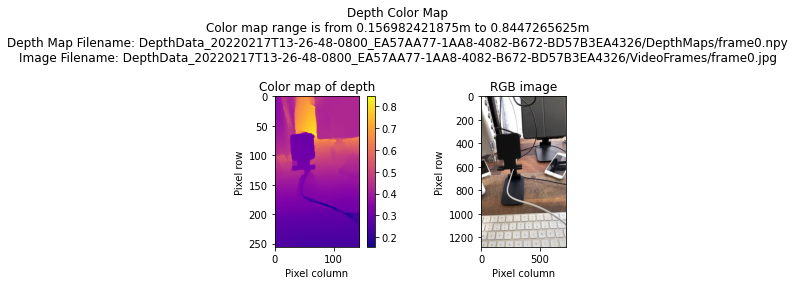

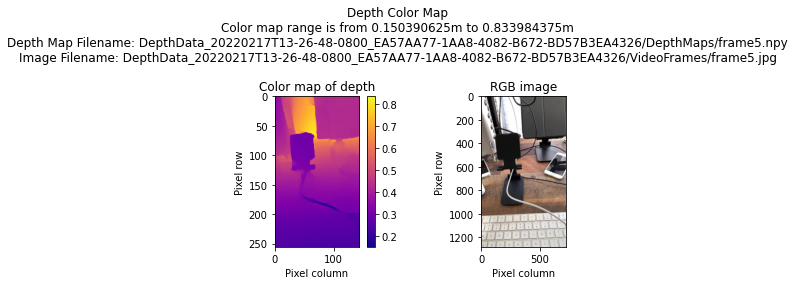

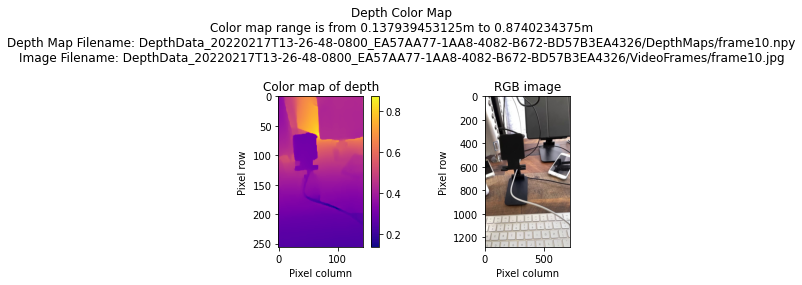

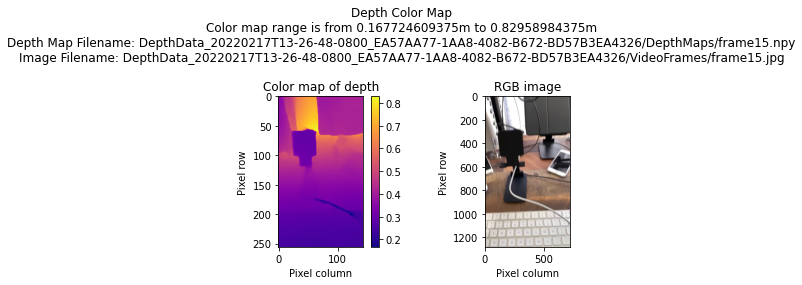

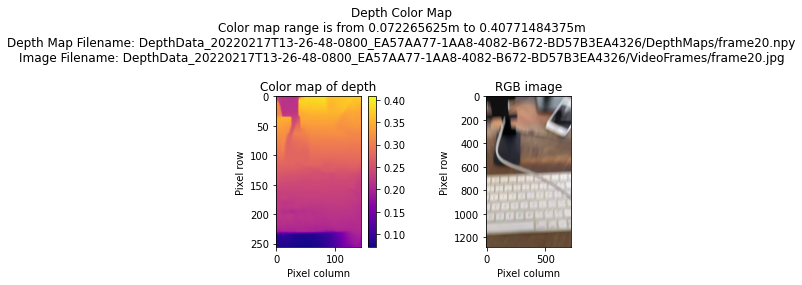

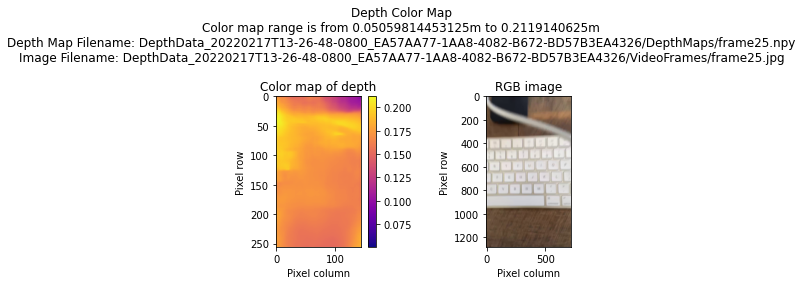

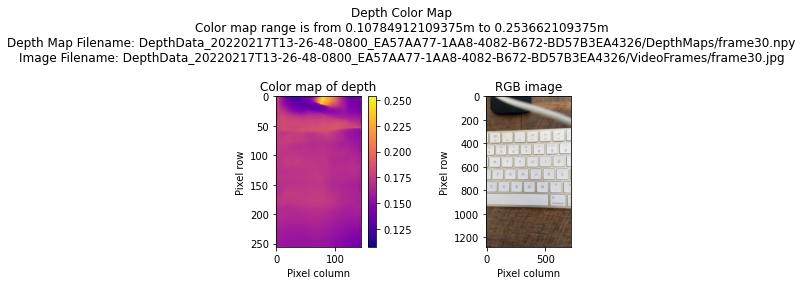

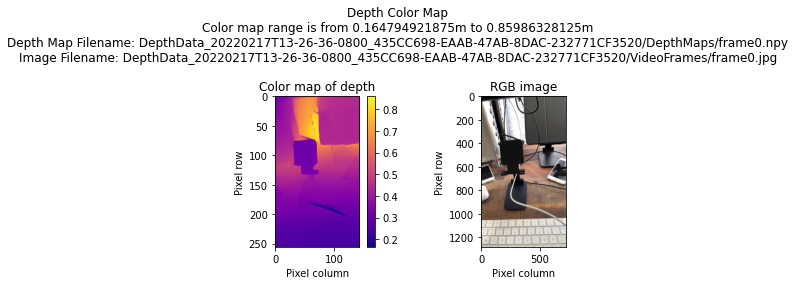

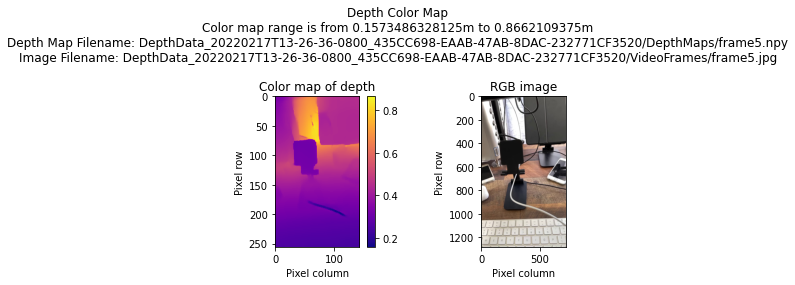

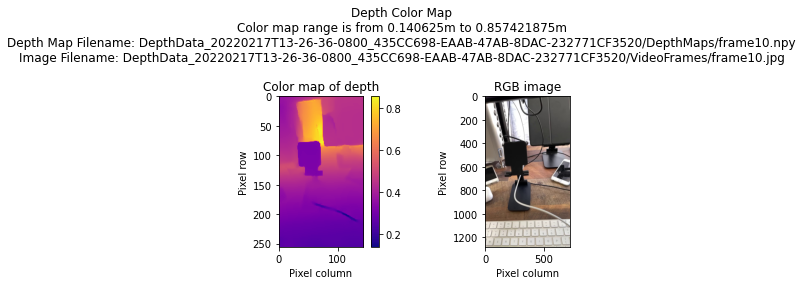

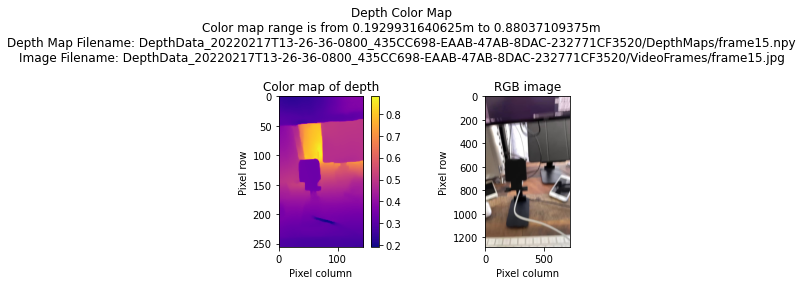

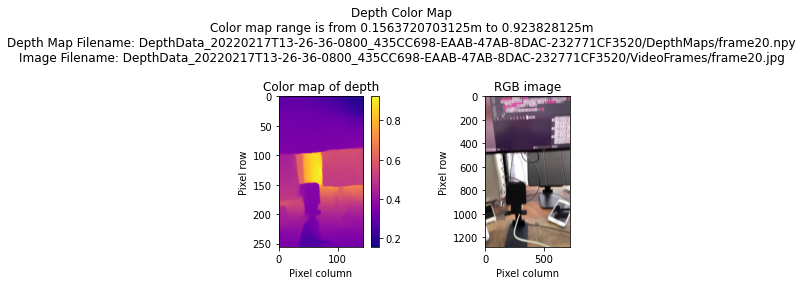

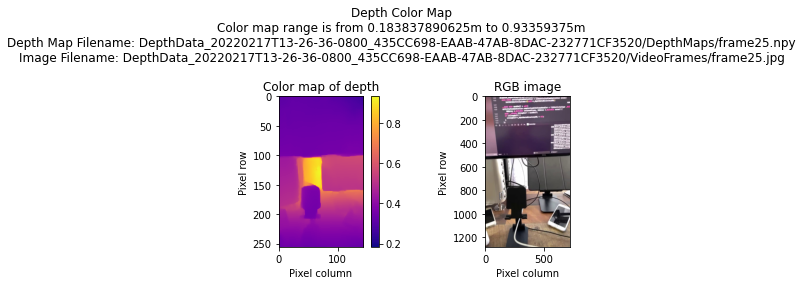

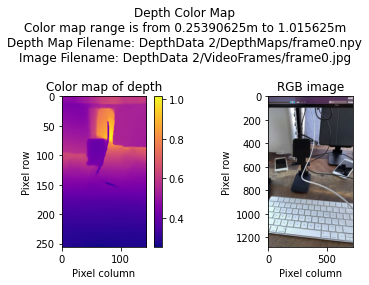

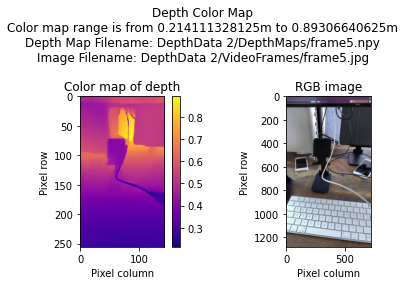

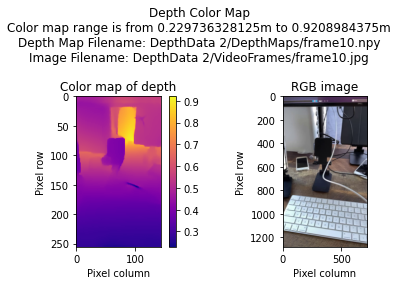

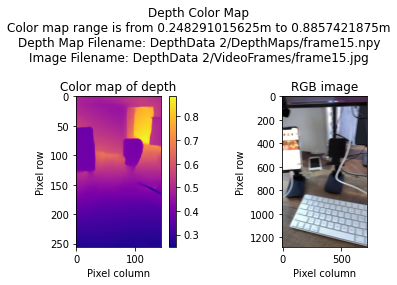

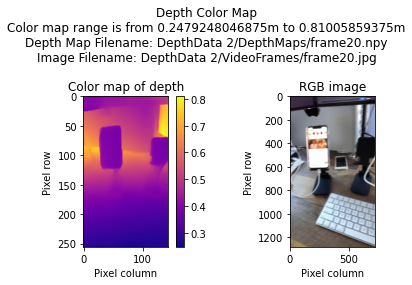

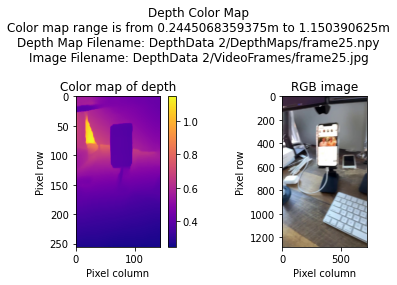

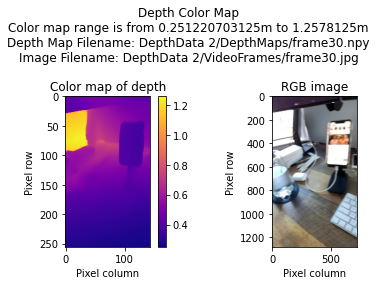

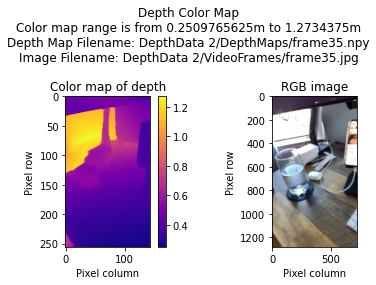

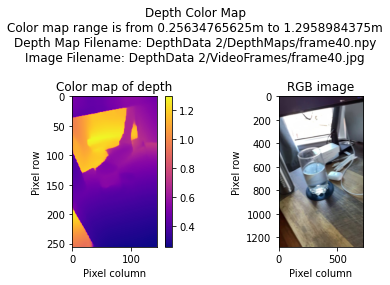

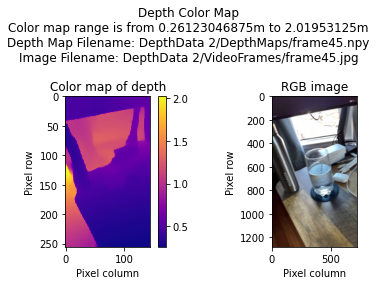

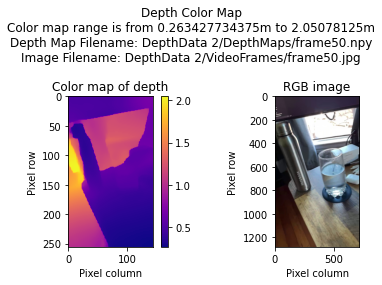

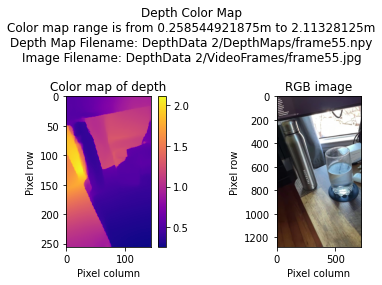

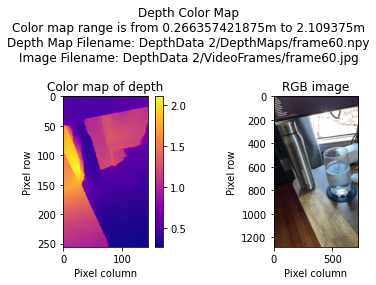

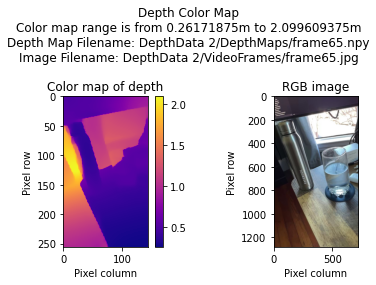

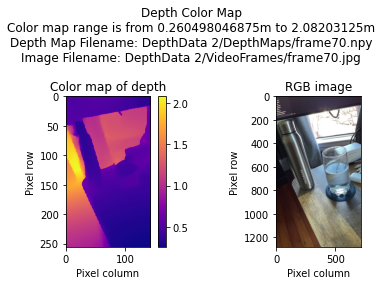

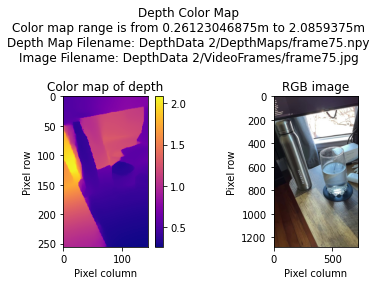

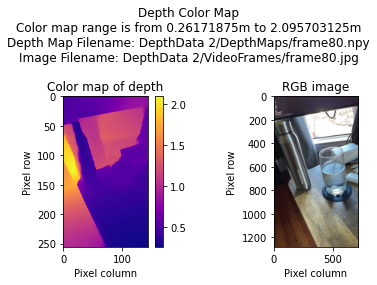

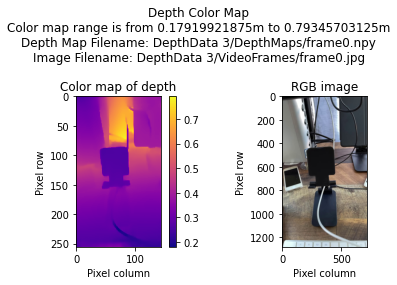

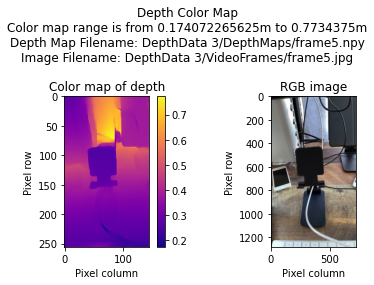

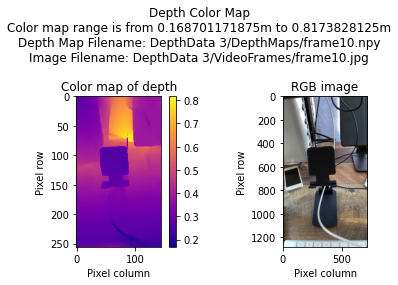

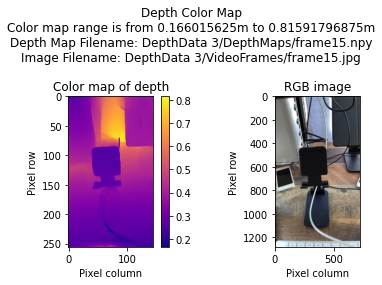

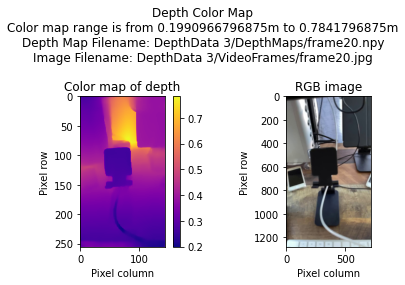

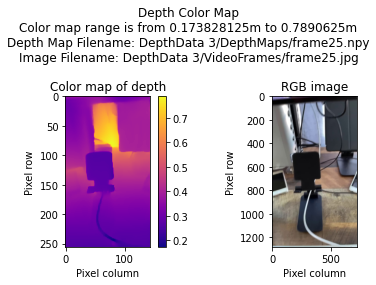

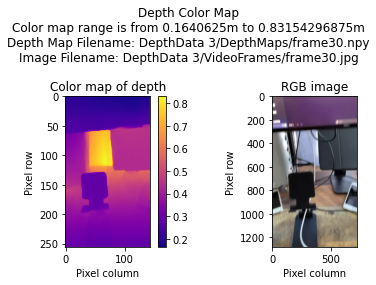

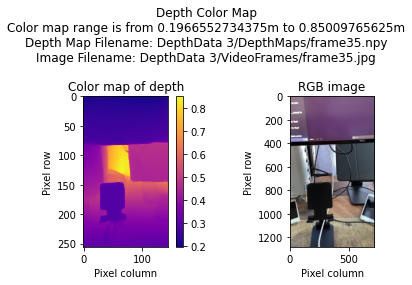

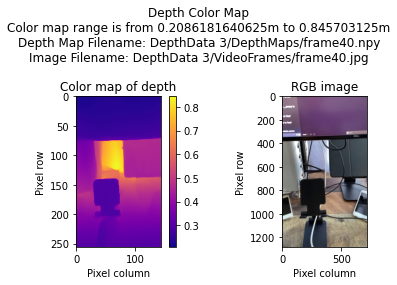

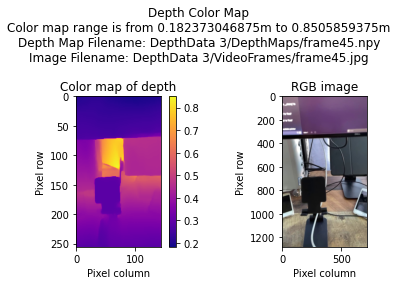

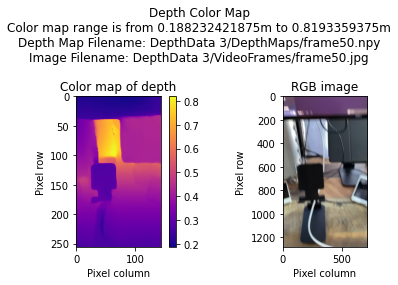

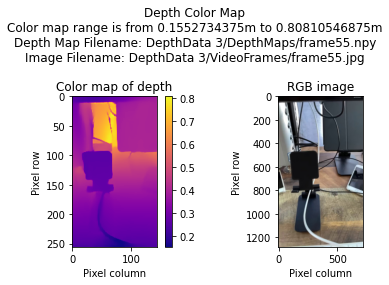

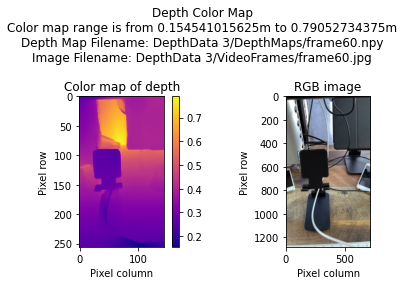

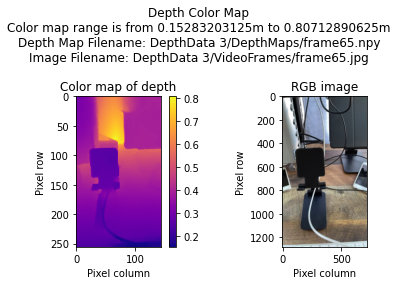

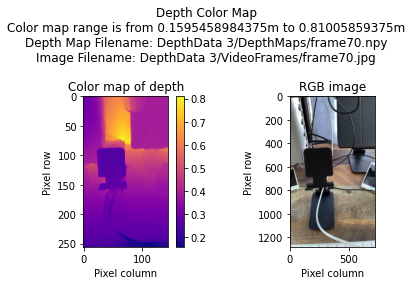

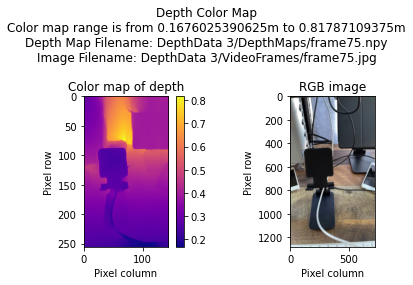

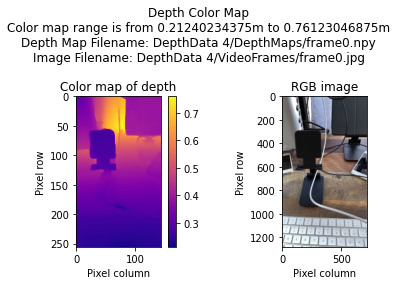

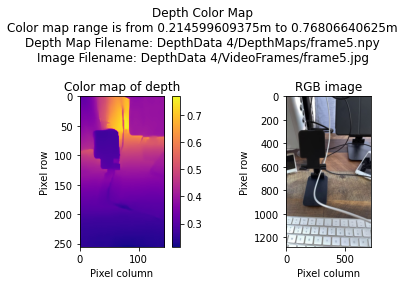

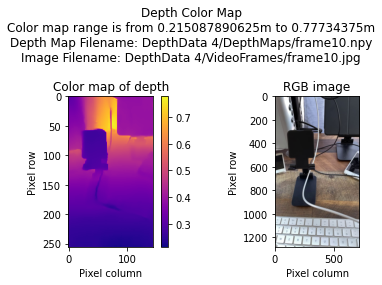

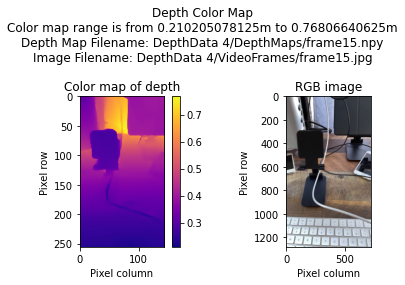

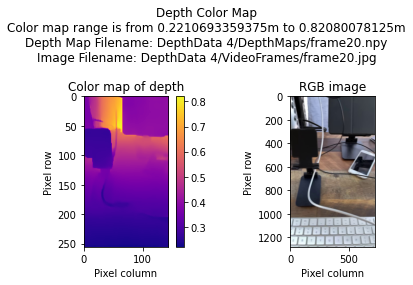

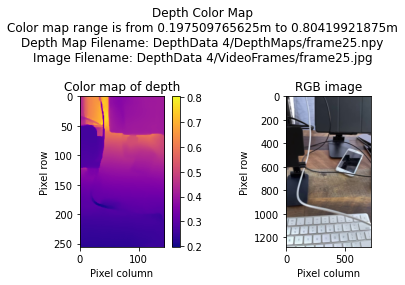

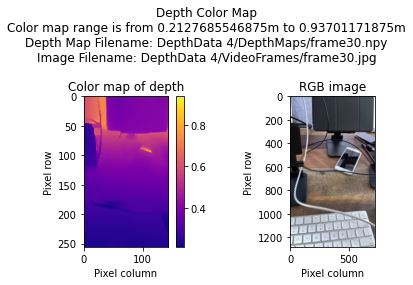

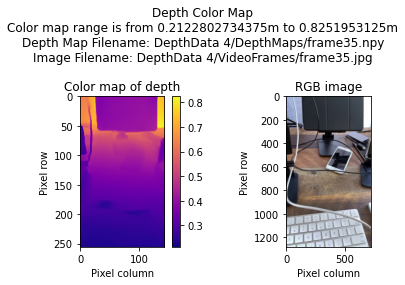

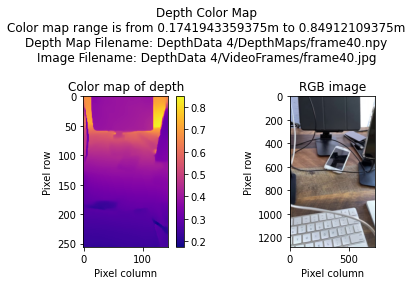

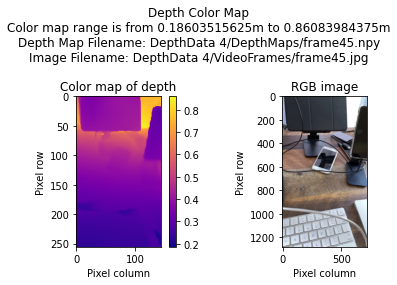

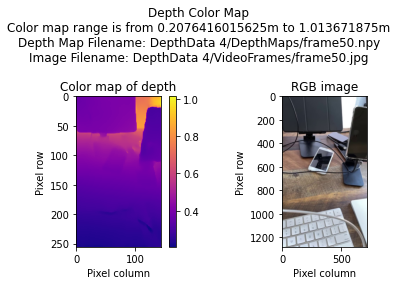

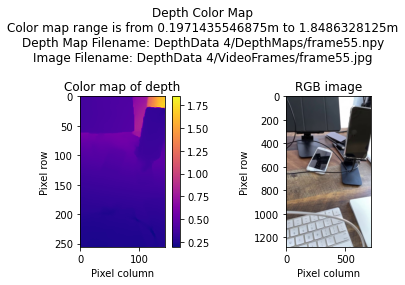

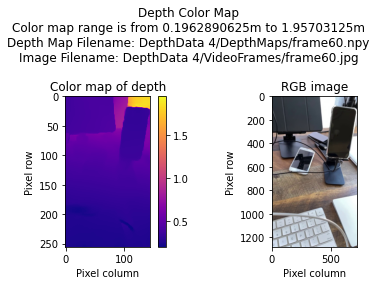

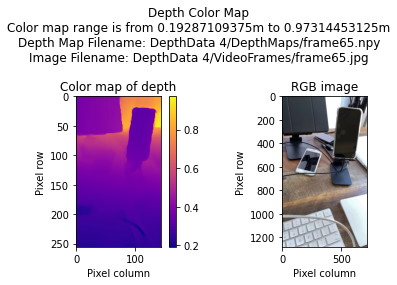

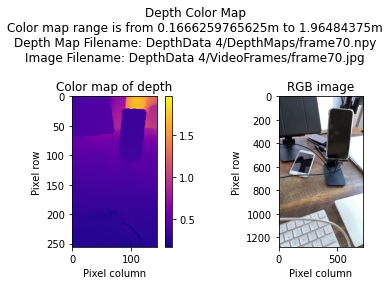

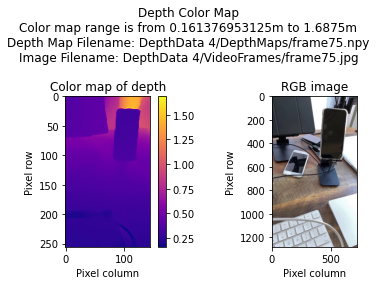

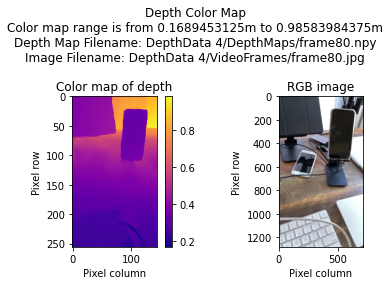

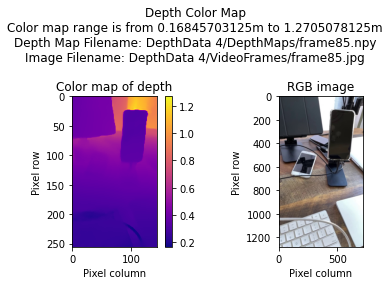

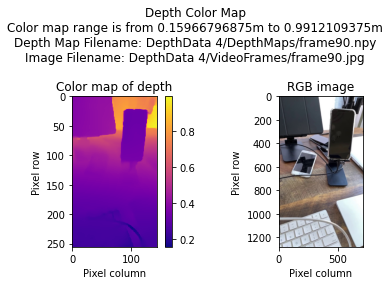

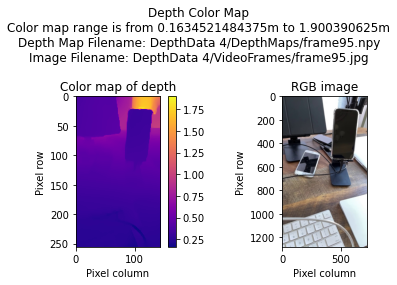

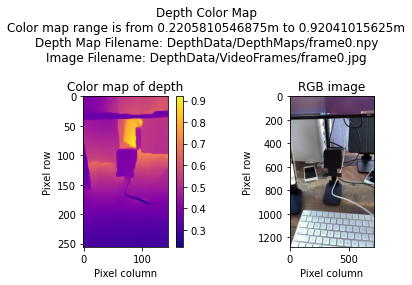

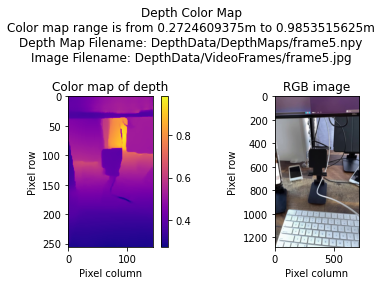

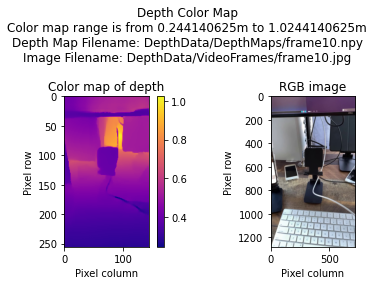

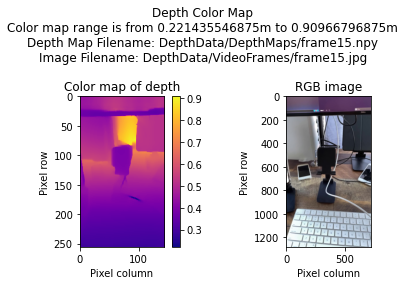

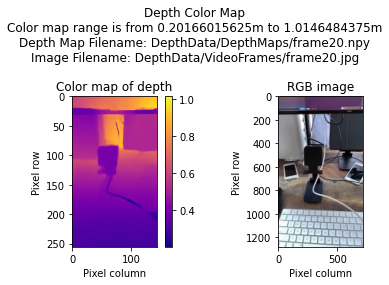

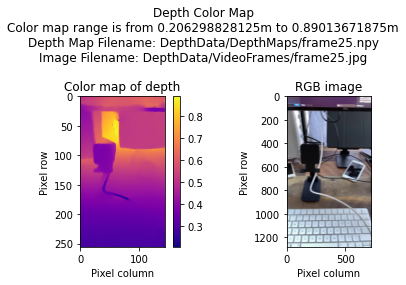

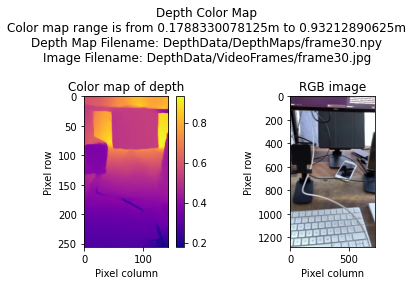

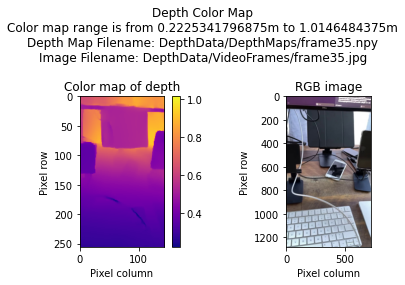

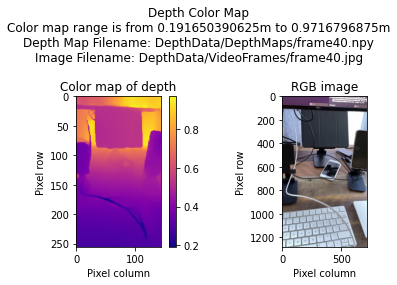

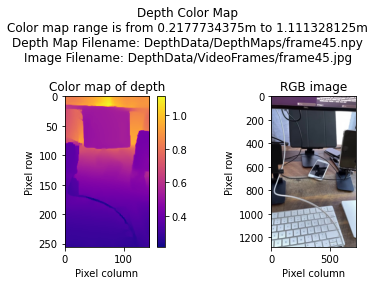

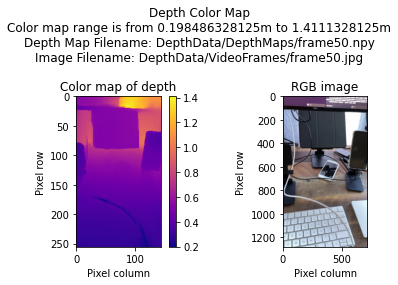

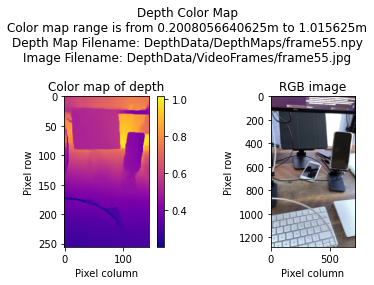

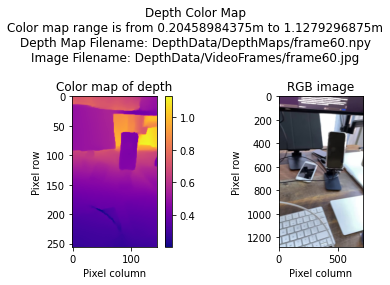

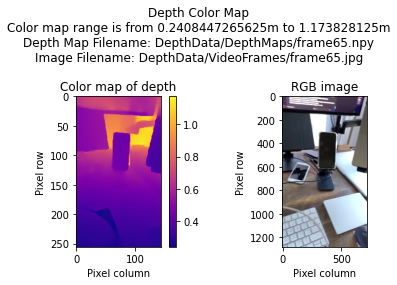

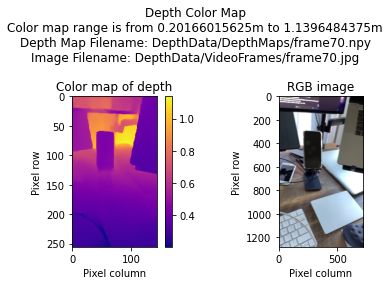

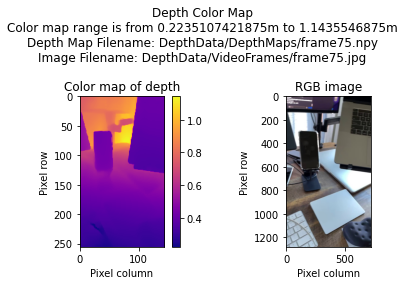

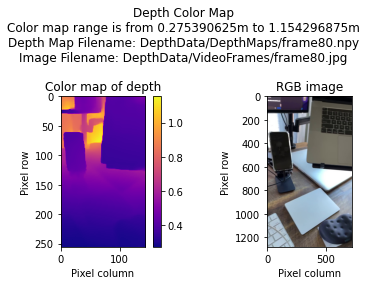

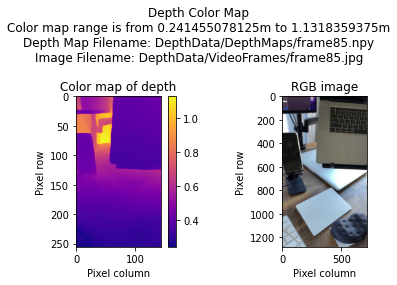

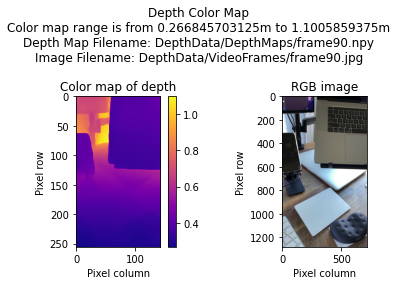

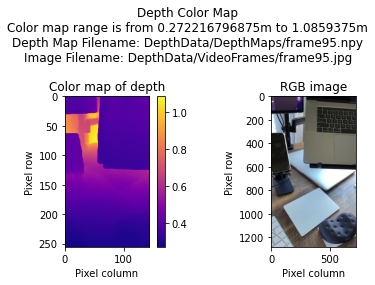

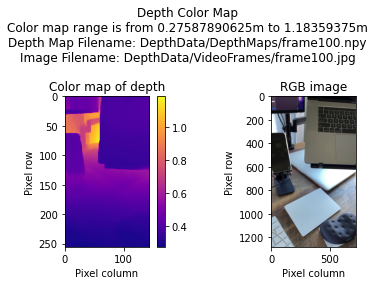

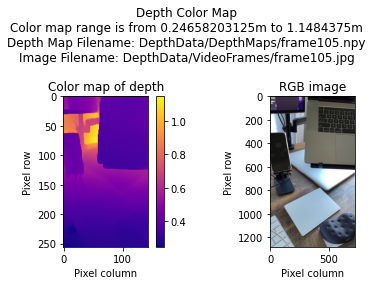

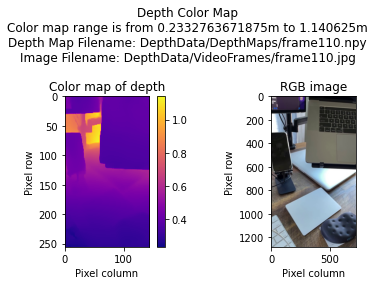

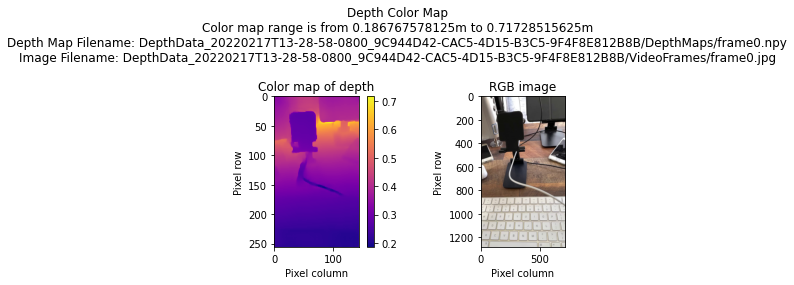

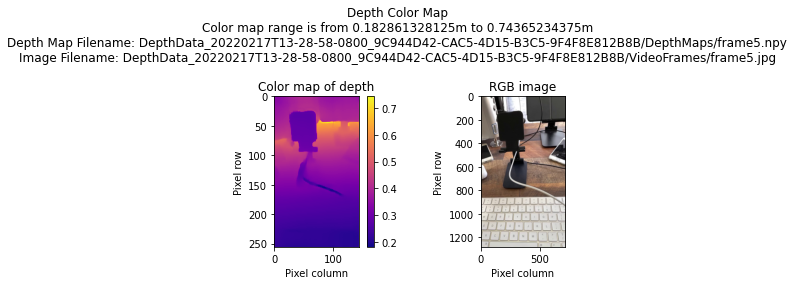

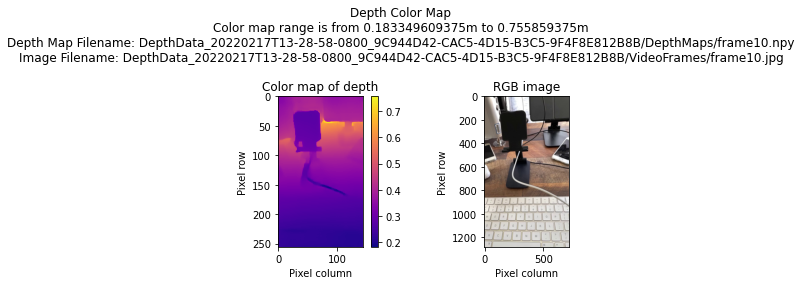

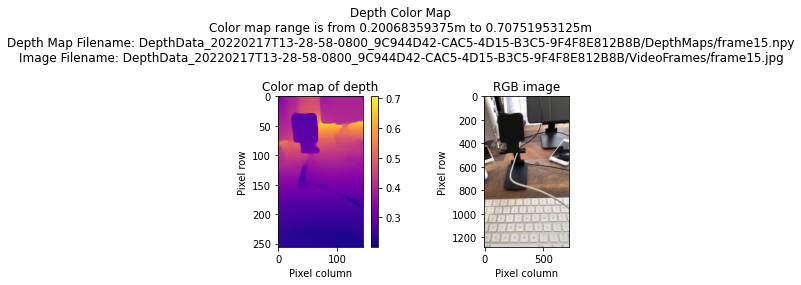

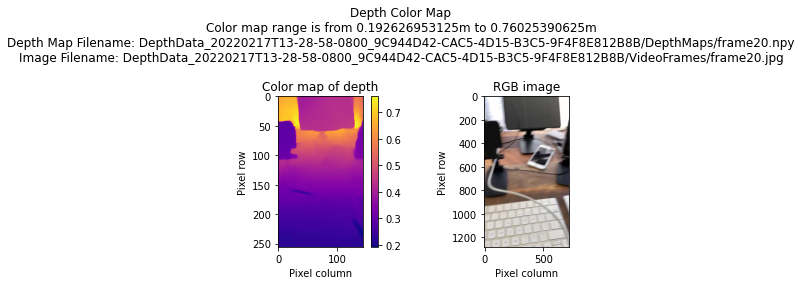

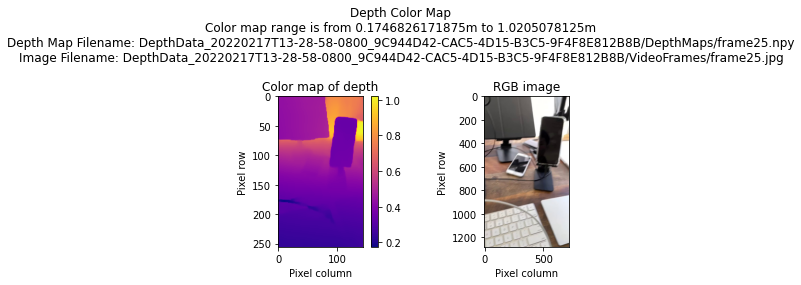

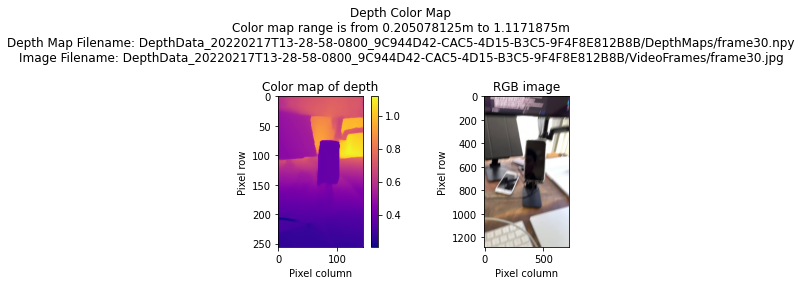

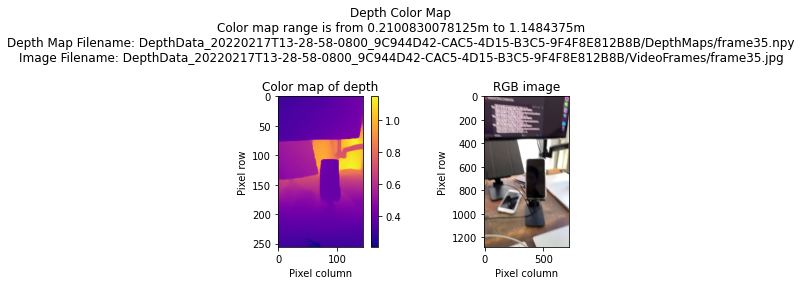

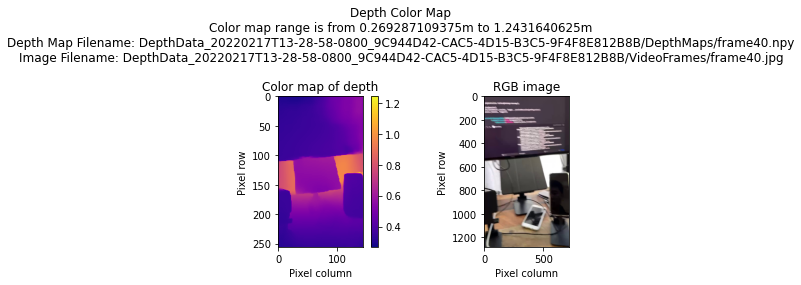

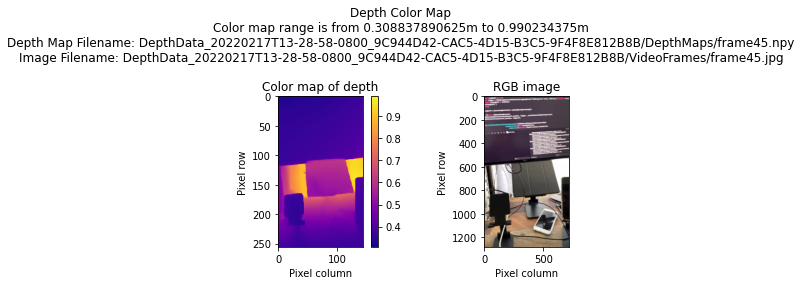

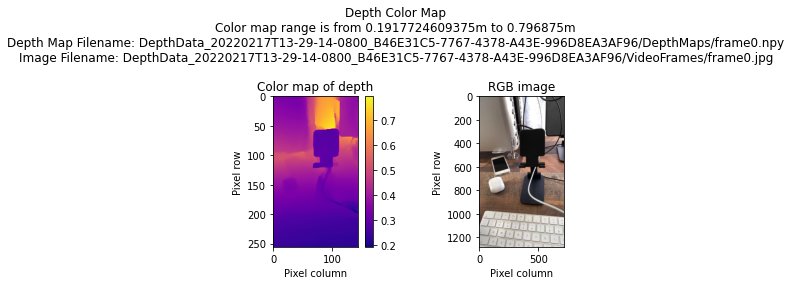

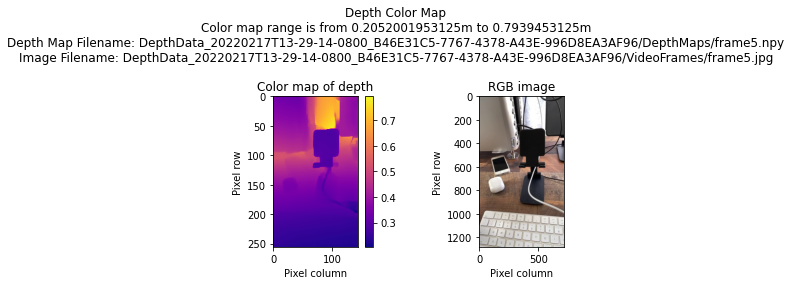

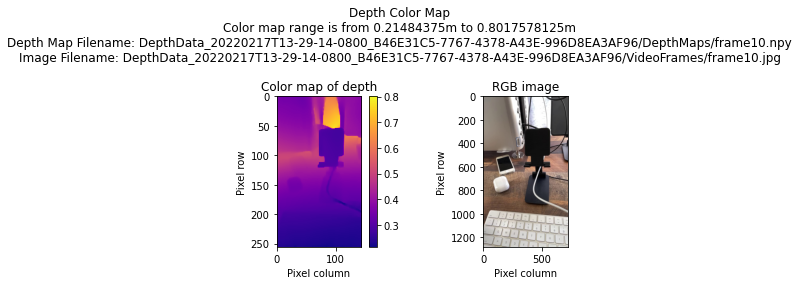

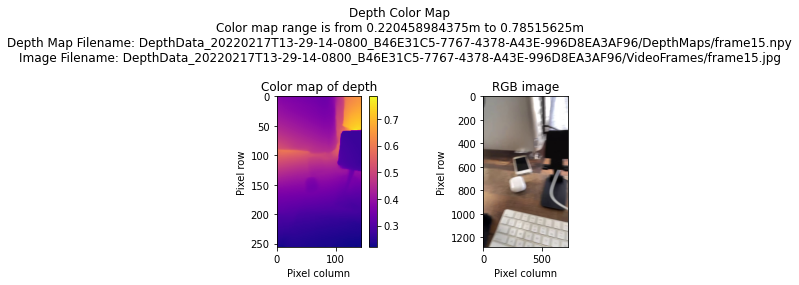

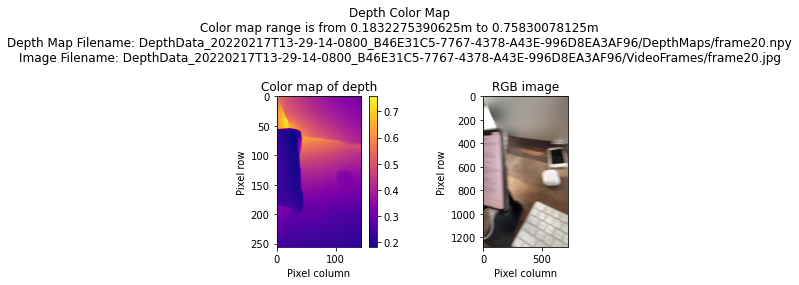

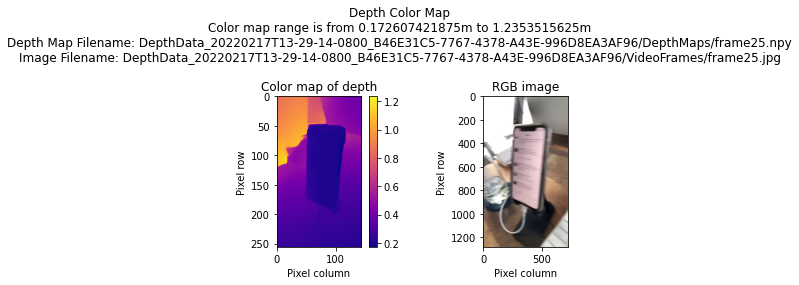

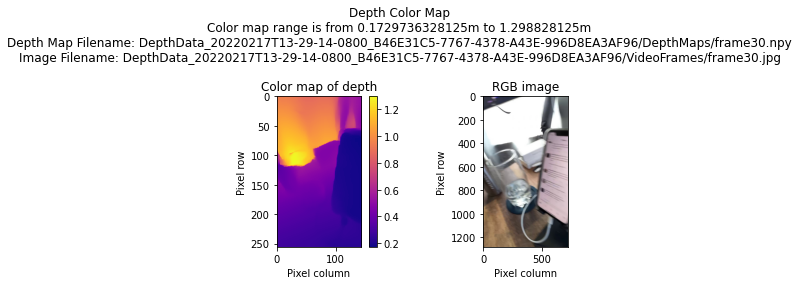

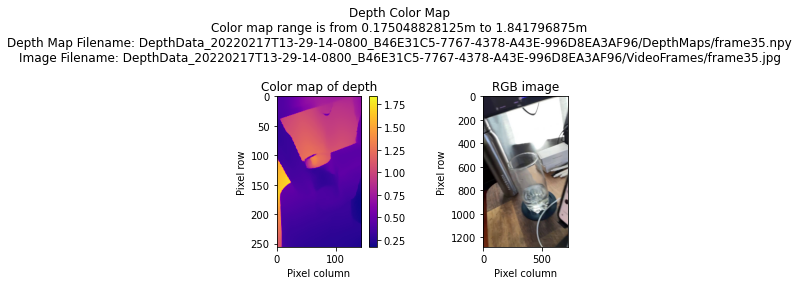

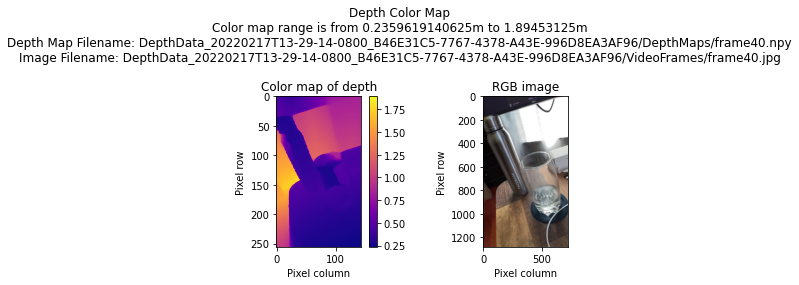

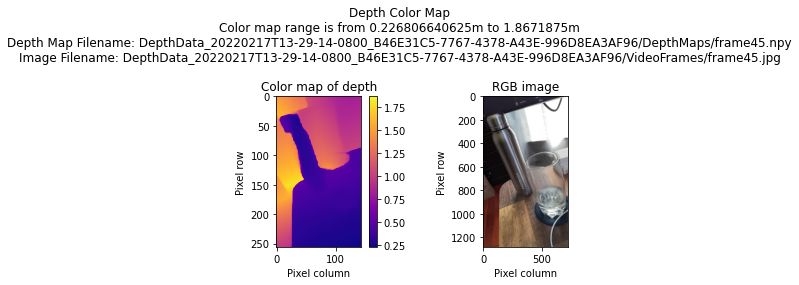

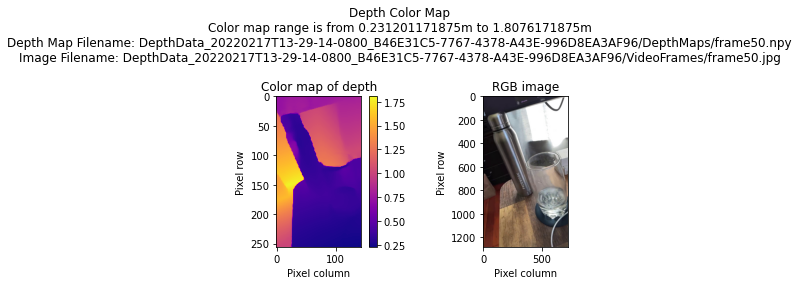

In [2]:
main(plot_data = True)